In [1]:
# 1. Mount Google Drive to access your repo files
from google.colab import drive
drive.mount('/content/drive')

# 2. Navigate to your project folder
# Replace 'your-repo-name' with your actual folder name
%cd "/content/drive/My Drive/Repositories/telco-customer-churn-prediction"

Mounted at /content/drive
/content/drive/My Drive/Repositories/telco-customer-churn-prediction


# 3.1 Library Setup & Data Loading

In [2]:
!nvidia-smi

Sun Nov 30 10:35:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install RAPIDS (if not already present in the specific runtime version)
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 223.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 156.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7

In [4]:
import cuml
import cudf

print(f"cuML version: {cuml.__version__}")
print(f"cuDF version: {cudf.__version__}")
print("GPU libraries loaded successfully!")

cuML version: 25.10.00
cuDF version: 25.10.00
GPU libraries loaded successfully!


In [7]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.9 MB/s eta 0:00:00


In [8]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Hyperparameter Tuning
import optuna

In [10]:
# Preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer

In [11]:
from sklearn.model_selection import train_test_split

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import os

In [12]:
# Algorithm for CPU
from sklearn.linear_model import LogisticRegression

In [13]:
# Algorithm for GPU
from cuml.linear_model import LogisticRegression as CuMLLogisticRegression

In [12]:
import xgboost as xgb

In [ ]:
# Model Saving
import joblib

In [15]:
# [IMPORTANT!] Change the Path When Going Back to VS Code! Add parameter engine='fastparquet'!
train_df = pd.read_parquet('/content/drive/MyDrive/Repositories/telco-customer-churn-prediction/data/processed/train_df.parquet')

# 3.2 Data Preprocessing

In [16]:
# Filter only the columns you selected
selected_features = ['trend_data_w2_vs_w1', 'trend_spend_w2_vs_w1', 'trend_data_w4_vs_w1',
                     'trend_data_w3_vs_w1', 'trend_spend_w4_vs_w1', 'trend_spend_w3_vs_w1',
                     'peak_data_week', 'lowest_data_week', 'peak_spend_week',
                     'ratio_min_daily_data_to_avg', 'ratio_min_daily_spend_to_avg',
                     'pct_video_w1', 'pct_video_w2', 'pct_video_w3', 'pct_video_w4',
                     'pct_messaging_w1', 'pct_messaging_w2', 'pct_messaging_w3',
                     'pct_messaging_w4', 'spend_consistency_score',
                     'data_volatility_shift', 'spend_volatility_shift',
                     'data_gini_coefficient']
target_col = 'churn'

# X and y setup
X = train_df[selected_features]
y = train_df[target_col]

In [17]:
# Create training and validation sets (for Modeling without Hyperparameter-Tuning)
# Use an 80/20 split: 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("--- Data Splitting Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train churn rate: {y_train.value_counts(normalize=True).loc[1]:.4f}")
print(f"y_val churn rate: {y_val.value_counts(normalize=True).loc[1]:.4f}")

--- Data Splitting Complete ---
X_train shape: (41603, 23)
X_val shape: (10401, 23)
y_train churn rate: 0.2312
y_val churn rate: 0.2311


# 3.3 Function for Evaluation Report

In [18]:
def churn_evaluation(model, X, y,
                      model_name="XGBoost Classifier",
                      # --- Business Parameters ---
                      ltv=500,            # Lifetime Value ($)
                      cost_offer=20,      # Cost of incentive ($)
                      cost_contact=1,     # Cost of contact ($)
                      acceptance_rate=0.5 # Probability churner accepts offer
                      ):

    # --- 1. Preparation ---
    # Ensure inputs are standard formatting
    y = np.array(y)

    # Get Probabilities (Critical for Lift & Thresholding)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model must support predict_proba for business calculations.")

    # Create a DataFrame for analysis
    df_res = pd.DataFrame({'y_true': y, 'y_prob': y_prob})
    df_res = df_res.sort_values('y_prob', ascending=False).reset_index(drop=True)

    # --- 2. The Profit Curve & Optimal Threshold ---
    # We calculate the business outcome at EVERY possible threshold (row by row)

    # Cumulative stats
    df_res['cum_tp'] = df_res['y_true'].cumsum()
    df_res['cum_fp'] = (1 - df_res['y_true']).cumsum()
    df_res['cum_total'] = df_res.index + 1

    # Business Formula
    # Profit = (Revenue from Saved Churners) - (Cost of Campaign)
    # Revenue = (True Positives * Acceptance_Rate * LTV)
    # Cost = (Contacted_Count * (Cost_Contact + Cost_Offer))

    df_res['campaign_cost'] = df_res['cum_total'] * (cost_contact + cost_offer)
    df_res['revenue_saved'] = df_res['cum_tp'] * acceptance_rate * ltv
    df_res['net_profit'] = df_res['revenue_saved'] - df_res['campaign_cost']

    # Find the Sweet Spot (Max Profit)
    max_profit_idx = df_res['net_profit'].idxmax()
    max_profit = df_res.loc[max_profit_idx, 'net_profit']
    optimal_threshold = df_res.loc[max_profit_idx, 'y_prob']
    optimal_customers = max_profit_idx + 1
    total_customers = len(df_res)

    # ROI at optimal point
    optimal_roi = (max_profit / df_res.loc[max_profit_idx, 'campaign_cost']) * 100

    # --- 3. Decile Analysis (The "Lift" Report) ---
    df_res['decile'] = pd.qcut(df_res.index, 10, labels=False) + 1
    lift_data = df_res.groupby('decile').agg(
        total_customers=('y_true', 'count'),
        actual_churners=('y_true', 'sum')
    ).sort_index()

    # Calculate Lift
    global_churn_rate = y.mean()
    lift_data['churn_rate'] = lift_data['actual_churners'] / lift_data['total_customers']
    lift_data['lift'] = lift_data['churn_rate'] / global_churn_rate

    top_decile_lift = lift_data.loc[1, 'lift'] # Decile 1 (Top 10%)

    # --- 4. Printing the Executive Report ---
    print(f"=========================================================")
    print(f"  EXECUTIVE SUMMARY: {model_name.upper()}")
    print(f"=========================================================\n")

    print(f"$$$ FINANCIAL IMPACT ANALYSIS (At Optimal Threshold: {optimal_threshold:.2f}) $$$")
    print(f"---------------------------------------------------------")
    print(f"Max Potential Profit:     ${max_profit:,.2f}")
    print(f"Return on Investment:     {optimal_roi:.1f}%")
    print(f"Target Volume:            {optimal_customers} customers ({optimal_customers/total_customers:.1%}% of base)")
    print(f"---------------------------------------------------------")

    print(f"\n>>> LIFT & PERFORMANCE METRICS")
    print(f"---------------------------------------------------------")
    print(f"Top Decile Lift:          {top_decile_lift:.2f}x (Industry Target: >3.0x)")
    print(f"AUC-ROC Score:            {roc_auc_score(y, y_prob):.3f}")

    # Recalculate Confusion Matrix at OPTIMAL threshold (not 0.5)
    y_pred_opt = (y_prob >= optimal_threshold).astype(int)
    print(f"\nClassification Report (Optimized for Profit):")
    print(classification_report(y, y_pred_opt, target_names=['Stay', 'Churn']))

    # --- 5. Visualizations ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.3)

    # A. Profit Curve
    axes[0,0].plot(df_res['cum_total'], df_res['net_profit'], color='green', linewidth=2)
    axes[0,0].scatter(optimal_customers, max_profit, color='red', s=100, zorder=5, label=f'Max Profit: ${max_profit:,.0f}')
    axes[0,0].axvline(optimal_customers, color='red', linestyle='--', alpha=0.5)
    axes[0,0].set_title(f'Profit Curve (Business Impact)', fontsize=14)
    axes[0,0].set_xlabel('Number of Customers Contacted (Sorted by Risk)')
    axes[0,0].set_ylabel('Net Profit ($)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # B. Cumulative Gains Curve (Industry Standard)
    # % of total churners captured by contacting top % of base
    axes[0,1].plot(df_res.index/total_customers, df_res['cum_tp']/df_res['y_true'].sum(), color='blue', linewidth=2, label='Model')
    axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    axes[0,1].set_title('Cumulative Gains Curve (Recall by Volume)', fontsize=14)
    axes[0,1].set_xlabel('% of Customer Base Contacted')
    axes[0,1].set_ylabel('% of All Churners Captured')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # C. Lift per Decile (Bar Chart)
    sns.barplot(x=lift_data.index, y=lift_data['lift'], ax=axes[1,0], palette="viridis")
    axes[1,0].axhline(1.0, color='red', linestyle='--', label='Baseline (Random)')
    axes[1,0].set_title('Lift by Decile (Top 10% vs Average)', fontsize=14)
    axes[1,0].set_ylabel('Lift Multiplier (x times better)')
    axes[1,0].set_xlabel('Decile (1=Highest Risk)')
    axes[1,0].legend()

    # D. Confusion Matrix (At Optimal Threshold)
    ConfusionMatrixDisplay.from_predictions(y, y_pred_opt, ax=axes[1,1], cmap='Blues', normalize=None, display_labels=['Stay', 'Churn'])
    axes[1,1].set_title(f'Confusion Matrix\n(Threshold = {optimal_threshold:.2f})', fontsize=14)

    plt.show()

In [ ]:
def evaluate_churn_business(model, X, y,
                            model_name="Logistic Regression",
                            file_prefix="lr_val",
                            # --- Business Parameters (Defaults based on Telco standards) ---
                            ltv=500,           # Lifetime Value of a retained customer
                            cost_offer=20,     # Cost of the incentive (discount/gift)
                            cost_contact=1,    # Cost to send email/SMS
                            acceptance_rate=0.5 # % of churners who stay after offer
                           ):

    print(f"--- Evaluating {model_name} (Business Context) ---")

    # 1. Predictions & Probabilities
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    else:
        print("Warning: Model does not support predict_proba. Profit Curve cannot be generated.")
        y_prob = y_pred # Fallback

    # 2. Standard Classification Report
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y, y_pred, target_names=['Not Churned (0)', 'Churned (1)']))

    # 3. Calculate Business Metrics (ROI)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Financial Formulas
    cost = (tp + fp) * (cost_offer + cost_contact)
    revenue_saved = tp * acceptance_rate * ltv
    net_profit = revenue_saved - cost
    roi = (net_profit / cost) * 100 if cost > 0 else 0

    print(f"\n$$$ Business Impact Report $$$")
    print(f"------------------------------")
    print(f"Targeted Customers: {tp + fp} (TP + FP)")
    print(f"Investment Cost:    ${cost:,.2f}")
    print(f"Revenue Saved:      ${revenue_saved:,.2f} (based on {acceptance_rate*100}% acceptance)")
    print(f"Net Profit:         ${net_profit:,.2f}")
    print(f"ROI:                {roi:.2f}%")
    print(f"------------------------------")

    # 4. Visualization Setup (3 subplots now)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot A: Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(
        model, X, y,
        display_labels=['Not Churned', 'Churned'],
        cmap='Blues',
        ax=axes[0], colorbar=False
    )
    axes[0].set_title(f'{model_name}\nConfusion Matrix')

    # Plot B: ROC-AUC Curve
    RocCurveDisplay.from_estimator(model, X, y, ax=axes[1])
    axes[1].set_title(f'{model_name}\nROC-AUC Curve')
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5) # Add diagonal line

    # Plot C: The Profit Curve (New!)
    # Sort data by probability to simulate targeting top % of risky customers
    df_profit = pd.DataFrame({'y_true': y, 'y_prob': y_prob})
    df_profit = df_profit.sort_values('y_prob', ascending=False).reset_index(drop=True)

    # Calculate cumulative TP and FP at each threshold
    df_profit['cum_tp'] = df_profit['y_true'].cumsum()
    df_profit['cum_fp'] = (1 - df_profit['y_true']).cumsum()

    # Calculate expected profit at every single cutoff point
    # Profit = (Cum_TP * Acceptance * LTV) - ((Cum_TP + Cum_FP) * (Offer + Contact))
    df_profit['expected_profit'] = (
        (df_profit['cum_tp'] * acceptance_rate * ltv) -
        ((df_profit['cum_tp'] + df_profit['cum_fp']) * (cost_offer + cost_contact))
    )

    # Plotting the curve
    axes[2].plot(df_profit.index, df_profit['expected_profit'], color='green', linewidth=2)

    # Find max profit point
    max_idx = df_profit['expected_profit'].idxmax()
    max_profit = df_profit.loc[max_idx, 'expected_profit']
    optimal_customers = max_idx + 1

    axes[2].scatter(max_idx, max_profit, color='red', zorder=5, label=f'Max Profit: ${max_profit:,.0f}')
    axes[2].set_title(f'{model_name}\nProfit Curve')
    axes[2].set_xlabel('Number of Customers Contacted')
    axes[2].set_ylabel('Estimated Net Profit ($)')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    print(f"Suggestion: To maximize profit, you should contact the top {optimal_customers} riskiest customers.")

# 3.3 (LogisticRegression) Modeling & Evaluation

## 3.3.1 Without Hyperparameter Tuning

In [20]:
# --- Preprocessing Pipeline ---
# PowerTransformer(method='yeo-johnson') makes data Gaussian-like and handles skew
numeric_transformer_nht = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing values
    ('transformer', PowerTransformer(method='yeo-johnson')), # Make Gaussian-like
    ('scaler', StandardScaler()) # Standard Scale
])

preprocessor_nht = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_nht, selected_features)
    ])

# --- Full Pipeline (Impute -> Transform -> SMOTE -> Model) ---
clf_nht = ImbPipeline(steps=[
    ('preprocessor', preprocessor_nht),
    # ('smote', SMOTE(sampling_strategy=0.33/0.67, random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

In [21]:
# --- Train the Logistic Regression Pipeline ---
print("--- Training the Logistic Regression Model ---")

# Fit the Logistic Regression pipeline on the training data
clf_nht.fit(X_train, y_train)

print("Logistic regression model trained successfully!")

--- Training the Logistic Regression Model ---
Logistic regression model trained successfully!


In [52]:
# Classification Report Function
def evaluate_classification(model, X, y, model_name="Logistic Regression", save_dir=None, file_prefix="lr_val"):
    print(f"--- Evaluating {model_name} ---")

    # Make Predictions
    y_pred = model.predict(X)

    # Classification Report
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y, y_pred, target_names=['Not Churned (0)', 'Churned (1)']))

    # 3. Confusion Matrix
    print(f"\nConfusion Matrix ({model_name}):")
    fig, ax = plt.subplots(figsize=(6, 5)) # Create a new figure
    ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y,
        display_labels=['Not Churned', 'Churned'],
        cmap='Blues',
        ax=ax
    )
    plt.title(f'{model_name} Confusion Matrix')

    # Save Logic
    if save_dir:
        os.makedirs(save_dir, exist_ok=True) # Ensure folder exists
        filename = f"confusion_matrix_{file_prefix}.png"
        file_path = os.path.join(save_dir, filename)
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved successfully to: {file_path}")

    plt.show()

    # ROC-AUC Curve
    print(f"\nROC-AUC Curve ({model_name}):")
    fig, ax = plt.subplots(figsize=(6, 5)) # Create a new figure
    RocCurveDisplay.from_estimator(
        model,
        X,
        y,
        ax=ax
    )
    plt.title(f'{model_name} ROC-AUC Curve')

    # Save Logic
    if save_dir:
        filename = f"ROC_{file_prefix}.png"
        file_path = os.path.join(save_dir, filename)
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        print(f"ROC saved successfully to: {file_path}")

    plt.show()

--- Evaluating Logistic Regression ---

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

Not Churned (0)       0.90      0.89      0.89     31985
    Churned (1)       0.65      0.66      0.65      9618

       accuracy                           0.84     41603
      macro avg       0.77      0.77      0.77     41603
   weighted avg       0.84      0.84      0.84     41603


Confusion Matrix (Logistic Regression):


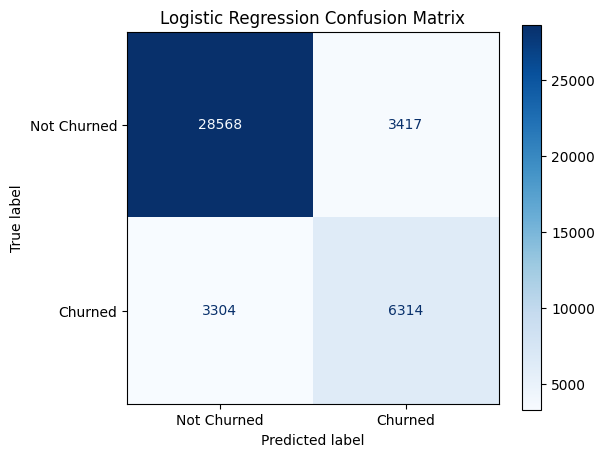


ROC-AUC Curve (Logistic Regression):


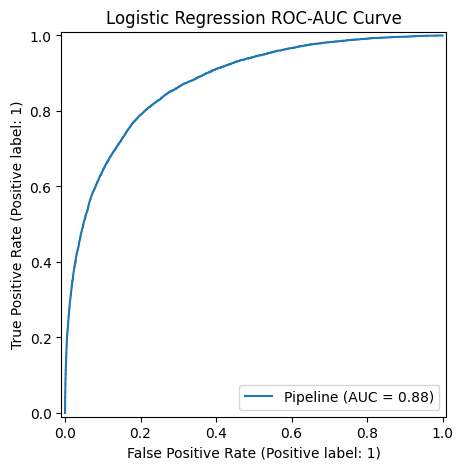

In [53]:
evaluate_classification(clf_nht, X_train, y_train, model_name="Logistic Regression")

--- Evaluating Logistic Regression ---

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

Not Churned (0)       0.89      0.89      0.89      7997
    Churned (1)       0.64      0.65      0.64      2404

       accuracy                           0.83     10401
      macro avg       0.77      0.77      0.77     10401
   weighted avg       0.84      0.83      0.83     10401


Confusion Matrix (Logistic Regression):


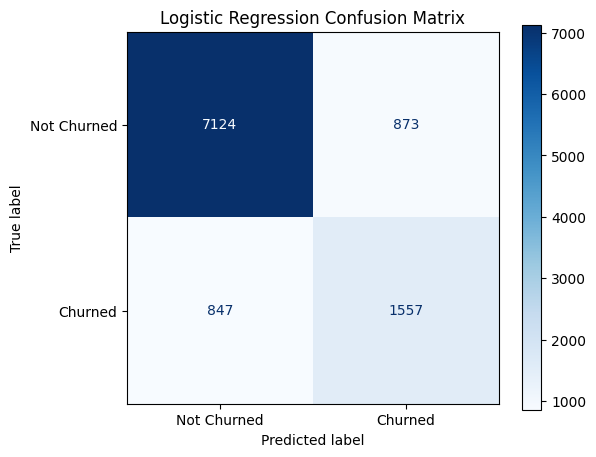


ROC-AUC Curve (Logistic Regression):


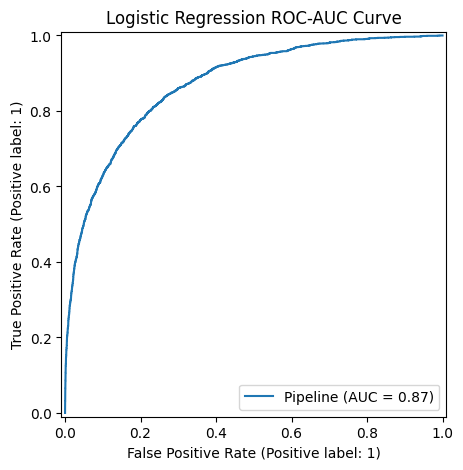

In [54]:
evaluate_classification(clf_nht, X_val, y_val, model_name="Logistic Regression")

## 3.3.2 Hyperparameter Tuning with Optuna

In [27]:
# Define the Objective Function
def objective(trial):
    # --- Hyperparameters to tune ---
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    # Note: 'elasticnet' works with 'saga'.
    # If pure l2 is chosen, l1_ratio is ignored by solver but required by API
    penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l2'])

    # --- Preprocessing Pipeline ---
    # PowerTransformer(method='yeo-johnson') makes data Gaussian-like and handles skew
    numeric_transformer = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Handle missing values
        ('transformer', PowerTransformer(method='yeo-johnson')), # Make Gaussian-like
        ('scaler', StandardScaler()) # Standard Scale
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selected_features)
        ])

    # --- Model Definition ---
    model = CuMLLogisticRegression(
        solver='qn',
        max_iter=1000,
        C=C,
        penalty=penalty,
        l1_ratio=l1_ratio,
        verbose=False,
        class_weight=None
    )

    # --- Full Pipeline (Impute -> Transform -> SMOTE -> Model) ---
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross Validation Strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Scoring
    scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')

    return scores.mean()

In [26]:
# Run Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Adjust trials as needed

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-11-30 09:23:56,728] A new study created in memory with name: no-name-c8da994f-1ff3-4b1b-96dc-fa373b8f1ac3
[I 2025-11-30 09:24:09,835] Trial 0 finished with value: 0.528891272022068 and parameters: {'C': 0.01048716091538424, 'l1_ratio': 0.6185700589219635, 'penalty': 'l2'}. Best is trial 0 with value: 0.528891272022068.
[I 2025-11-30 09:24:16,087] Trial 1 finished with value: 0.5292184427246374 and parameters: {'C': 0.002702843327888638, 'l1_ratio': 0.17182435596246592, 'penalty': 'l2'}. Best is trial 1 with value: 0.5292184427246374.
[I 2025-11-30 09:24:21,687] Trial 2 finished with value: 0.5290830923158355 and parameters: {'C': 87.37449186264669, 'l1_ratio': 0.7360518009987244, 'penalty': 'l2'}. Best is trial 1 with value: 0.5292184427246374.
[I 2025-11-30 09:24:28,588] Trial 3 finished with value: 0.5291101176120346 and parameters: {'C': 5.036841917519901, 'l1_ratio': 0.8540960527417747, 'penalty': 'elasticnet'}. Best is trial 1 with value: 0.5292184427246374.
[I 2025-11-30 

Best Score: 0.5292645653879486
Best Params: {'C': 0.0035044813238793936, 'l1_ratio': 0.994534895071556, 'penalty': 'l2'}


In [ ]:
# Re-instantiate standard sklearn model for the final save
final_cpu_model = LogisticRegression(
    solver='saga', # Back to CPU solver
    penalty=study.best_params['penalty'],
    C=study.best_params['C'],
    l1_ratio=study.best_params['l1_ratio'],
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

In [ ]:
# Re-create pipeline with best model
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
            ('num', ImbPipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('transformer', PowerTransformer(method='yeo-johnson')),
                ('scaler', StandardScaler())
            ]), selected_features)
        ])),
    ('classifier', final_cpu_model)
])

final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['data_usage_change_2wk',
                                                   'spend_change_2wk',
                                                   'video_data_change_2wk',
                                                   'messaging_data_change_2wk',
                                                   'pct_data_on_video_w3_4',
                                                   'pct_data_on_messaging_w3_4'])])),
                ('classifier',
                 LogisticRegression(C=0.006407002786069587,
                                    class_weight='balanced',
                                    l1_ratio=0.9093687088414236, max_iter=1000,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

--- Evaluating Final Logistic Regression ---

Classification Report (Final Logistic Regression):
                 precision    recall  f1-score   support

Not Churned (0)       0.91      0.73      0.81     39982
    Churned (1)       0.46      0.75      0.57     12022

       accuracy                           0.73     52004
      macro avg       0.68      0.74      0.69     52004
   weighted avg       0.80      0.73      0.75     52004


Confusion Matrix (Final Logistic Regression):


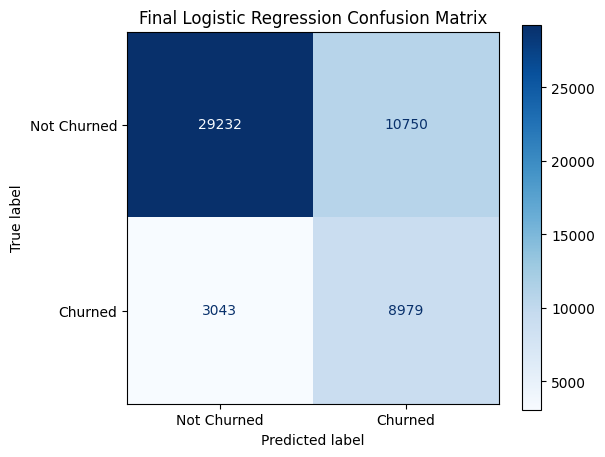


ROC-AUC Curve (Final Logistic Regression):


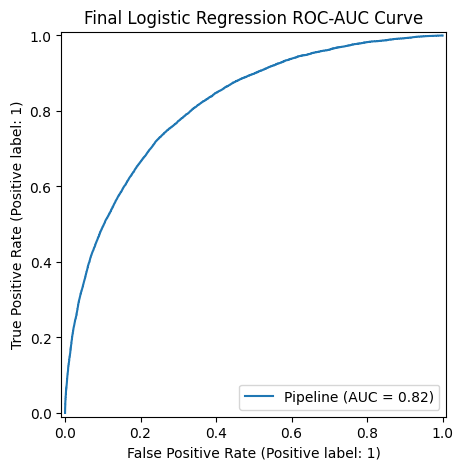

In [ ]:
# Evaluating Model Performance
evaluate_classification(final_pipeline, X, y, model_name="Final Logistic Regression")

# 3.4 XGBoost-Modeling & Evaluation

In [ ]:
# Create the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), selected_features)
    ],
    remainder='drop' # Drop any column not in selected_features
)

In [ ]:
# 4. Define Optuna Objective Function
def objective(trial):
    # Hyperparameters search space
    params = {
        'device': 'cuda', # Use T4 GPU
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': 3.33,
        'n_estimators': 1000, # Allow early stopping to cut this short
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'verbosity': 0
    }

    # Construct the full pipeline with the classifier
    # We pass the params into the XGBClassifier
    clf = xgb.XGBClassifier(**params)

    model_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Cross Validation Strategy
    # StratifiedKFold is strictly required for imbalanced data (23% positive)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # We score based on RECALL as requested
    scores = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1
    )

    return scores.mean()

In [ ]:
# Run Optimization
study = optuna.create_study(direction='maximize')
print("Starting Hyperparameter Tuning on GPU...")
study.optimize(objective, n_trials=100)

print(f"Best Recall: {study.best_value:.4f}")
print("Best Params:", study.best_params)

[I 2025-11-27 17:02:21,895] A new study created in memory with name: no-name-3c63ebca-3e8b-4da6-b49f-b4d10a92aeb1


Starting Hyperparameter Tuning on GPU...


[I 2025-11-27 17:02:41,998] Trial 0 finished with value: 0.5924222318903622 and parameters: {'learning_rate': 0.024739973720189844, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.614670097974872, 'colsample_bytree': 0.5450792336676573, 'reg_alpha': 0.0023968314469938047, 'reg_lambda': 0.0011820503333787237, 'gamma': 0.0011630694102577896}. Best is trial 0 with value: 0.5924222318903622.
[I 2025-11-27 17:02:55,891] Trial 1 finished with value: 0.5961652250919263 and parameters: {'learning_rate': 0.01846537776983366, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9979165929171449, 'colsample_bytree': 0.689740743570043, 'reg_alpha': 2.5168738197921288, 'reg_lambda': 4.4909497870247965e-05, 'gamma': 0.0011632233414202418}. Best is trial 1 with value: 0.5961652250919263.
[I 2025-11-27 17:03:05,656] Trial 2 finished with value: 0.5937821028477923 and parameters: {'learning_rate': 0.06417364607204849, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9758508430994294, 'colsa

KeyboardInterrupt: 

In [ ]:
# Save as .pkl
joblib.dump(final_pipeline, 'final_churn_model.pkl')